In [1]:
from tensorflow import keras
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Reshape, UpSampling1D
from keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import load_model

import csv
import librosa
import librosa.display
import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

from scipy.io import wavfile
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
seed = 2024

In [3]:
def plot_accuracy_and_loss(history_df, name, idx):
    # Plot and save accuraccy
    plt.plot(history_df['accuracy'])
    plt.plot(history_df['val_accuracy'])
    plt.title(f'{name}: accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    path = f'train_history/{name}/{idx}_accuracy.png'
    plt.savefig(path)
    print(f'Accuracy plot is saved to: {path}')
    plt.close()
    # Plot and save loss
    plt.figure()
    plt.plot(history_df['loss'])
    plt.plot(history_df['val_loss'])
    plt.title(f'{name}: loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    path = f'train_history/{name}/{idx}_loss.png'
    plt.savefig(path)
    print(f'Loss plot is saved to: {path}')
    plt.close()

def plot_confusion_matrix(name, idx):
    model = keras.models.load_model('train_history/'+name+'/.keras')
    y_pred = np.argmax(model.predict(X_val), axis=-1)

    cm = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
    accuracy = accuracy_score(y_val, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(0, 10), yticklabels=range(0, 10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{name} Confusion Matrix. Accuracy: {accuracy * 100:.2f}%')
    path = f'train_history/{name}/{idx}_confusion_matrix.png'
    plt.savefig(path)
    print(f'Confusion matrix is saved to: {path}')
    plt.close()
    return accuracy

In [5]:
noise_coef = 0.1
silence_coef = 0.1
drop_out_rate = 0.5
num_epochs = 10
num_silences = 1700
audio_length = 16000
sample_rate = 16000
classes = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'silence', 'stop', 'unknown', 'up', 'yes']

# To hold waves as xs and labels as y of training
train_samples = []
train_labels = []
noise_samples = []
for noises in os.listdir('../data/train/train/audio/_background_noise_'):
    if noises[-4:] != '.wav':
        continue
    noise_sample_rate, noise_sample = wavfile.read(os.path.join('../data/train/train/audio/_background_noise_', noises))
    #noise_resampled = librosa.resample(noise_sample.astype(np.float), orig_sr=noise_sample_rate, target_sr=sample_rate)
    noise_resampled = noise_sample
    noise_samples.append(noise_resampled)

# Loading all the waves and labels
for trains in os.listdir('../data/train/train/audio'):
    if trains == '_background_noise_':
        continue
    for wav_file in os.listdir(os.path.join('../data/train/train/audio', trains)):
        if wav_file[-4:] != '.wav':
            continue
        sample_rate_init, sample = wavfile.read(os.path.join(os.path.join('../data/train/train/audio', trains), wav_file))
        signal_resampled = sample
        #signal_resampled = librosa.resample(sample.astype(np.float), orig_sr=sample_rate_init, target_sr=sample_rate)
        if len(signal_resampled) != audio_length:
            zeros_needed = audio_length - len(signal_resampled)
            signal_resampled = np.append(signal_resampled, np.zeros((zeros_needed))) # if the length is not right just pad with zeros
        #adding noise to the samples
        nois_type_indx = np.random.randint(0, len(noise_samples), 1)
        nois_sample_indx = np.random.randint(0, len(noise_samples[int(nois_type_indx)]) - audio_length, 1)
        sample_noise = signal_resampled + noise_coef * noise_samples[int(nois_type_indx)][int(nois_sample_indx):int(nois_sample_indx) + audio_length]
        train_samples.append(sample_noise)
        if trains not in ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']:
            train_labels.append('unknown')
        else:
            train_labels.append(trains)

# adding portions of weakened background noise as silence
for num_sil in range(num_silences):
    silence_type_indx = np.random.randint(0, len(noise_samples), 1)
    silence_sample_indx = np.random.randint(0, len(noise_samples[int(silence_type_indx)]) - audio_length, 1)
    sample_silence = silence_coef * noise_samples[int(silence_type_indx)][int(silence_sample_indx):int(silence_sample_indx) + audio_length]
    train_labels.append('silence')
    train_samples.append(sample_silence)
    
# converting labels from text to int
le = LabelEncoder()
y_all = le.fit_transform(train_labels)
y = keras.utils.to_categorical(y_all, len(le.classes_))
# To make sure all arrays are having a defined size
X_train, X_val, y_train, y_val = train_test_split(train_samples, y, test_size=0.2, random_state=seed)

C:\Users\megav\AppData\Local\Temp\ipykernel_26832\2818814623.py:17: WavFileWarning: Chunk (non-data) not understood, skipping it.
  noise_sample_rate, noise_sample = wavfile.read(os.path.join('../data/train/train/audio/_background_noise_', noises))
C:\Users\megav\AppData\Local\Temp\ipykernel_26832\2818814623.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nois_sample_indx = np.random.randint(0, len(noise_samples[int(nois_type_indx)]) - audio_length, 1)
C:\Users\megav\AppData\Local\Temp\ipykernel_26832\2818814623.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample_noise = signal_resampled + noise_coef * noise_samples[int(nois_

In [20]:
X_train = np.reshape(X_train, (len(X_train), len(X_train[0]), 1))
X_val = np.reshape(X_val, (len(X_val), len(X_val[0]), 1))

## Test 1: ConvS2S

In [6]:
keras.utils.set_random_seed(seed)
accuracy = []
batch_size=32
n_epochs=10
optimizer='adam'
loss='mse'

# Define ConvS2S model architecture
def build_convs2s(input_shape, output_length, num_filters=64, kernel_size=3):
    # Encoder
    inputs = Input(shape=input_shape)
    conv1 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(inputs)
    maxpool1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(maxpool1)
    maxpool2 = MaxPooling1D(pool_size=2)(conv2)
    flatten = Flatten()(maxpool2)
    encoder_output = Dense(num_filters, activation='relu')(flatten)

    # Decoder
    decoder_input = Dense(output_length*num_filters, activation='relu')(encoder_output)
    reshape = Reshape((output_length, num_filters))(decoder_input)
    conv3 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(reshape)
    upsample1 = UpSampling1D(size=2)(conv3)
    conv4 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(upsample1)
    upsample2 = UpSampling1D(size=2)(conv4)
    decoder_output = Conv1D(1, 37, activation='linear')(upsample2)

    # Build and compile model
    model = Model(inputs=inputs, outputs=decoder_output)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

# Usage:
input_shape = (16000, 1)
output_length = 12
convs2s_model = build_convs2s(input_shape, output_length)

# Train the model
history = convs2s_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_val, y_val))

Epoch 1/10
1661/1661 [==============================] - 1931s 1s/step - loss: 24799.5273 - accuracy: 0.6828 - val_loss: 1.2038 - val_accuracy: 0.7870
Epoch 2/10
1661/1661 [==============================] - 1894s 1s/step - loss: 14.7909 - accuracy: 0.8724 - val_loss: 0.0509 - val_accuracy: 0.9369
Epoch 3/10
1661/1661 [==============================] - 2590s 2s/step - loss: 0.0511 - accuracy: 0.9362 - val_loss: 0.0505 - val_accuracy: 0.9369
Epoch 4/10
1661/1661 [==============================] - 2106s 1s/step - loss: 0.0508 - accuracy: 0.9362 - val_loss: 0.0503 - val_accuracy: 0.9369
Epoch 5/10
1661/1661 [==============================] - 1982s 1s/step - loss: 0.0506 - accuracy: 0.9362 - val_loss: 0.0501 - val_accuracy: 0.9369
Epoch 6/10
1448/1661 [=========================>....] - ETA: 4:20 - loss: 0.0506 - accuracy: 0.9361

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model/max_pooling1d/MaxPool/MaxPoolGrad' defined at (most recent call last):
    File "C:\Users\XXX\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\XXX\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\XXX\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\XXX\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\XXX\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\XXX\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\XXX\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\XXX\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\XXX\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\XXX\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\XXX\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\XXX\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\XXX\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\XXX\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\XXX\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\XXX\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "C:\Users\XXX\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\XXX\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\XXX\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\XXX\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\XXX\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\XXX\AppData\Local\Temp\ipykernel_12820\3048059351.py", line 40, in <module>
      history = convs2s_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_val, y_val))
    File "C:\Users\XXX\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\XXX\anaconda3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\XXX\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\XXX\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\XXX\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\XXX\anaconda3\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\XXX\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\XXX\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "C:\Users\XXX\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model/max_pooling1d/MaxPool/MaxPoolGrad'
OOM when allocating tensor with shape[32,16000,1,64] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node gradient_tape/model/max_pooling1d/MaxPool/MaxPoolGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1852]

In [11]:
name = 'convs2s_1' 

convs2s_model.save(f'train_history/{name}.keras')
history_df = pd.DataFrame(history.history) 
hist_csv_file = 'train_history/' + name + '/' + str(idx) + '_history.csv'
with open(hist_csv_file, mode='w') as f:
    history_df.to_csv(f)
plot_accuracy_and_loss(history_df, name, str(idx))
curr_accuracy = plot_confusion_matrix(name, str(idx))
accuracy.append(curr_accuracy)
print(f'Attempt accuracy: {curr_accuracy * 100:.2f}%')
    
accuracy_df = pd.DataFrame(data=accuracy, columns = ['accuracy'])
accuracy_csv_file = 'train_history/' + name + '/accuracy.csv'
with open(accuracy_csv_file, mode='w') as f:
    accuracy_df.to_csv(f)
print(f'Attempts accuracy is saved to {accuracy_csv_file}')

NameError: name 'history' is not defined

In [7]:
name = 'convs2s_2'
keras.utils.set_random_seed(seed)
accuracy = []
batch_size=32
n_epochs=5
optimizer='adamax'
loss='mse'

# Define ConvS2S model architecture
def build_convs2s(input_shape, output_length, num_filters=64, kernel_size=3):
    # Encoder
    inputs = Input(shape=input_shape)
    conv1 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(inputs)
    maxpool1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(maxpool1)
    maxpool2 = MaxPooling1D(pool_size=2)(conv2)
    flatten = Flatten()(maxpool2)
    encoder_output = Dense(num_filters, activation='relu')(flatten)

    # Decoder
    decoder_input = Dense(output_length*num_filters, activation='relu')(encoder_output)
    reshape = Reshape((output_length, num_filters))(decoder_input)
    conv3 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(reshape)
    upsample1 = UpSampling1D(size=2)(conv3)
    conv4 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(upsample1)
    upsample2 = UpSampling1D(size=2)(conv4)
    decoder_output = Conv1D(1, 37, activation='linear')(upsample2)

    # Build and compile model
    model = Model(inputs=inputs, outputs=decoder_output)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

# Usage:
input_shape = (16000, 1)
output_length = 12
convs2s_model = build_convs2s(input_shape, output_length)

# Train the model
history = convs2s_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_val, y_val))

Epoch 1/5
1661/1661 [==============================] - 1878s 1s/step - loss: 18029.3086 - accuracy: 0.5933 - val_loss: 7.8794 - val_accuracy: 0.4969
Epoch 2/5
1661/1661 [==============================] - 1802s 1s/step - loss: 35.0591 - accuracy: 0.6632 - val_loss: 1.9260 - val_accuracy: 0.6587
Epoch 3/5
1661/1661 [==============================] - 1795s 1s/step - loss: 19.4979 - accuracy: 0.6989 - val_loss: 1.3874 - val_accuracy: 0.5069
Epoch 4/5
1661/1661 [==============================] - 1802s 1s/step - loss: 14.2842 - accuracy: 0.7674 - val_loss: 0.2318 - val_accuracy: 0.8878
Epoch 5/5
1661/1661 [==============================] - 1816s 1s/step - loss: 0.1838 - accuracy: 0.9177 - val_loss: 0.0659 - val_accuracy: 0.9222


In [12]:
convs2s_model = load_model('train_history/convs2s_2.keras')

In [13]:
convs2s_model.save(f'train_history/{name}/.keras')
history_df = pd.DataFrame(history.history) 
hist_csv_file = 'train_history/' + name + '/' + 'history.csv'
with open(hist_csv_file, mode='w') as f:
    history_df.to_csv(f)
plot_accuracy_and_loss(history_df, name, str(1))
curr_accuracy = plot_confusion_matrix(name, str(1))
accuracy.append(curr_accuracy)
print(f'Attempt accuracy: {curr_accuracy * 100:.2f}%')
    
accuracy_df = pd.DataFrame(data=accuracy, columns = ['accuracy'])
accuracy_csv_file = 'train_history/' + name + '/accuracy.csv'
with open(accuracy_csv_file, mode='w') as f:
    accuracy_df.to_csv(f)
print(f'Attempts accuracy is saved to {accuracy_csv_file}')

Accuracy plot is saved to: train_history/convs2s_5/1_accuracy.png
Loss plot is saved to: train_history/convs2s_5/1_loss.png
416/416 [==============================] - 139s 332ms/step
Accuracy: 0.00%
Confusion matrix is saved to: train_history/convs2s_5/1_confusion_matrix.png
Attempt accuracy: 0.00%
Attempts accuracy is saved to train_history/convs2s_5/accuracy.csv


In [6]:
name = 'convs2s_3'
keras.utils.set_random_seed(seed)
accuracy = []
batch_size=32
n_epochs=5
optimizer='sgd'
loss='mse'

# Define ConvS2S model architecture
def build_convs2s(input_shape, output_length, num_filters=64, kernel_size=3):
    # Encoder
    inputs = Input(shape=input_shape)
    conv1 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(inputs)
    maxpool1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(maxpool1)
    maxpool2 = MaxPooling1D(pool_size=2)(conv2)
    flatten = Flatten()(maxpool2)
    encoder_output = Dense(num_filters, activation='relu')(flatten)

    # Decoder
    decoder_input = Dense(output_length*num_filters, activation='relu')(encoder_output)
    reshape = Reshape((output_length, num_filters))(decoder_input)
    conv3 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(reshape)
    upsample1 = UpSampling1D(size=2)(conv3)
    conv4 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(upsample1)
    upsample2 = UpSampling1D(size=2)(conv4)
    decoder_output = Conv1D(1, 37, activation='linear')(upsample2)

    # Build and compile model
    model = Model(inputs=inputs, outputs=decoder_output)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

# Usage:
input_shape = (16000, 1)
output_length = 12
convs2s_model = build_convs2s(input_shape, output_length)

# Train the model
history = convs2s_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_val, y_val))

Epoch 1/5
1661/1661 [==============================] - 1779s 1s/step - loss: nan - accuracy: 0.9160 - val_loss: nan - val_accuracy: 0.9167
Epoch 2/5
1661/1661 [==============================] - 1742s 1s/step - loss: nan - accuracy: 0.9167 - val_loss: nan - val_accuracy: 0.9167
Epoch 3/5
1661/1661 [==============================] - 1729s 1s/step - loss: nan - accuracy: 0.9167 - val_loss: nan - val_accuracy: 0.9167
Epoch 4/5
1661/1661 [==============================] - 1720s 1s/step - loss: nan - accuracy: 0.9167 - val_loss: nan - val_accuracy: 0.9167
Epoch 5/5
1661/1661 [==============================] - 1756s 1s/step - loss: nan - accuracy: 0.9167 - val_loss: nan - val_accuracy: 0.9167


In [31]:
convs2s_model.save(f'train_history/{name}/.keras')
history_df = pd.DataFrame(history.history) 
hist_csv_file = 'train_history/' + name + '/' + 'history.csv'
with open(hist_csv_file, mode='w') as f:
    history_df.to_csv(f)
plot_accuracy_and_loss(history_df, name, str(1))
curr_accuracy = plot_confusion_matrix(name, str(1))
accuracy.append(curr_accuracy)
print(f'Attempt accuracy: {curr_accuracy * 100:.2f}%')
    
accuracy_df = pd.DataFrame(data=accuracy, columns = ['accuracy'])
accuracy_csv_file = 'train_history/' + name + '/accuracy.csv'
with open(accuracy_csv_file, mode='w') as f:
    accuracy_df.to_csv(f)
print(f'Attempts accuracy is saved to {accuracy_csv_file}')

Accuracy plot is saved to: train_history/convs2s_3/1_accuracy.png
Loss plot is saved to: train_history/convs2s_3/1_loss.png
416/416 [==============================] - 120s 287ms/step
Accuracy: 0.00%
Confusion matrix is saved to: train_history/convs2s_3/1_confusion_matrix.png
Attempt accuracy: 0.00%
Attempts accuracy is saved to train_history/convs2s_3/accuracy.csv


In [7]:
keras.utils.set_random_seed(seed)
accuracy = []
batch_size=32
n_epochs=5
optimizer='adam'
loss='categorical_crossentropy'

# Define ConvS2S model architecture
def build_convs2s(input_shape, output_length, num_filters=64, kernel_size=3):
    # Encoder
    inputs = Input(shape=input_shape)
    conv1 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(inputs)
    maxpool1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(maxpool1)
    maxpool2 = MaxPooling1D(pool_size=2)(conv2)
    flatten = Flatten()(maxpool2)
    encoder_output = Dense(num_filters, activation='relu')(flatten)

    # Decoder
    decoder_input = Dense(output_length*num_filters, activation='relu')(encoder_output)
    reshape = Reshape((output_length, num_filters))(decoder_input)
    conv3 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(reshape)
    upsample1 = UpSampling1D(size=2)(conv3)
    conv4 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(upsample1)
    upsample2 = UpSampling1D(size=2)(conv4)
    decoder_output = Conv1D(1, 37, activation='linear')(upsample2)

    # Build and compile model
    model = Model(inputs=inputs, outputs=decoder_output)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

# Usage:
input_shape = (16000, 1)
output_length = 12
convs2s_model = build_convs2s(input_shape, output_length)

# Train the model
history = convs2s_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_val, y_val))

Epoch 1/5
1661/1661 [==============================] - 1857s 1s/step - loss: 9.4958 - accuracy: 0.5586 - val_loss: 13.9840 - val_accuracy: 0.6054
Epoch 2/5
1661/1661 [==============================] - 1826s 1s/step - loss: 2.3145 - accuracy: 0.6055 - val_loss: 2.1341 - val_accuracy: 0.6054
Epoch 3/5
1661/1661 [==============================] - 2071s 1s/step - loss: 2.1400 - accuracy: 0.6055 - val_loss: 2.1341 - val_accuracy: 0.6054
Epoch 4/5
1661/1661 [==============================] - 1926s 1s/step - loss: 2.1400 - accuracy: 0.6055 - val_loss: 2.1341 - val_accuracy: 0.6054
Epoch 5/5
1661/1661 [==============================] - 1844s 1s/step - loss: 2.1400 - accuracy: 0.6055 - val_loss: 2.1341 - val_accuracy: 0.6054


In [9]:
name = 'convs2s_4'

convs2s_model.save(f'train_history/{name}/.keras')
history_df = pd.DataFrame(history.history) 
hist_csv_file = 'train_history/' + name + '/' + 'history.csv'
with open(hist_csv_file, mode='w') as f:
    history_df.to_csv(f)
plot_accuracy_and_loss(history_df, name, str(1))
curr_accuracy = plot_confusion_matrix(name, str(1))
accuracy.append(curr_accuracy)
print(f'Attempt accuracy: {curr_accuracy * 100:.2f}%')
    
accuracy_df = pd.DataFrame(data=accuracy, columns = ['accuracy'])
accuracy_csv_file = 'train_history/' + name + '/accuracy.csv'
with open(accuracy_csv_file, mode='w') as f:
    accuracy_df.to_csv(f)
print(f'Attempts accuracy is saved to {accuracy_csv_file}')

Accuracy plot is saved to: train_history/convs2s_4/1_accuracy.png
Loss plot is saved to: train_history/convs2s_4/1_loss.png
416/416 [==============================] - 130s 310ms/step
Accuracy: 0.00%
Confusion matrix is saved to: train_history/convs2s_4/1_confusion_matrix.png
Attempt accuracy: 0.00%
Attempts accuracy is saved to train_history/convs2s_4/accuracy.csv


In [6]:
name = 'convs2s_5'
keras.utils.set_random_seed(seed)
accuracy = []
batch_size=32
n_epochs=5
optimizer='RMSprop'
loss='mse'

# Define ConvS2S model architecture
def build_convs2s(input_shape, output_length, num_filters=64, kernel_size=3):
    # Encoder
    inputs = Input(shape=input_shape)
    conv1 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(inputs)
    maxpool1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(maxpool1)
    maxpool2 = MaxPooling1D(pool_size=2)(conv2)
    flatten = Flatten()(maxpool2)
    encoder_output = Dense(num_filters, activation='relu')(flatten)

    # Decoder
    decoder_input = Dense(output_length*num_filters, activation='relu')(encoder_output)
    reshape = Reshape((output_length, num_filters))(decoder_input)
    conv3 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(reshape)
    upsample1 = UpSampling1D(size=2)(conv3)
    conv4 = Conv1D(num_filters, kernel_size, activation='relu', padding='same')(upsample1)
    upsample2 = UpSampling1D(size=2)(conv4)
    decoder_output = Conv1D(1, 37, activation='linear')(upsample2)

    # Build and compile model
    model = Model(inputs=inputs, outputs=decoder_output)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

# Usage:
input_shape = (16000, 1)
output_length = 12
convs2s_model = build_convs2s(input_shape, output_length)

# Train the model
history = convs2s_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_val, y_val))

Epoch 1/5
1661/1661 [==============================] - 2022s 1s/step - loss: 1826488.1250 - accuracy: 0.9172 - val_loss: 0.0504 - val_accuracy: 0.9369
Epoch 2/5
1661/1661 [==============================] - 3166s 2s/step - loss: 0.0508 - accuracy: 0.9362 - val_loss: 0.0506 - val_accuracy: 0.9369
Epoch 3/5
1661/1661 [==============================] - 2122s 1s/step - loss: 0.0507 - accuracy: 0.9362 - val_loss: 0.0501 - val_accuracy: 0.9369
Epoch 4/5
1661/1661 [==============================] - 1997s 1s/step - loss: 0.0506 - accuracy: 0.9362 - val_loss: 0.0502 - val_accuracy: 0.9369
Epoch 5/5
1661/1661 [==============================] - 2508s 2s/step - loss: 0.0506 - accuracy: 0.9361 - val_loss: 0.0502 - val_accuracy: 0.9369


In [7]:
convs2s_model.save(f'train_history/{name}/.keras')
history_df = pd.DataFrame(history.history) 
hist_csv_file = 'train_history/' + name + '/' + 'history.csv'
with open(hist_csv_file, mode='w') as f:
    history_df.to_csv(f)
plot_accuracy_and_loss(history_df, name, str(1))
curr_accuracy = plot_confusion_matrix(name, str(1))
accuracy.append(curr_accuracy)
print(f'Attempt accuracy: {curr_accuracy * 100:.2f}%')
    
accuracy_df = pd.DataFrame(data=accuracy, columns = ['accuracy'])
accuracy_csv_file = 'train_history/' + name + '/accuracy.csv'
with open(accuracy_csv_file, mode='w') as f:
    accuracy_df.to_csv(f)
print(f'Attempts accuracy is saved to {accuracy_csv_file}')

Accuracy plot is saved to: train_history/convs2s_5/1_accuracy.png
Loss plot is saved to: train_history/convs2s_5/1_loss.png
416/416 [==============================] - 121s 287ms/step
Accuracy: 0.00%
Confusion matrix is saved to: train_history/convs2s_5/1_confusion_matrix.png
Attempt accuracy: 0.00%
Attempts accuracy is saved to train_history/convs2s_5/accuracy.csv


416/416 [==============================] - 3s 8ms/step
Accuracy: 60.29%


Text(0.5, 1.0, 'Conv2S Confusion Matrix. Accuracy: 60.29%')

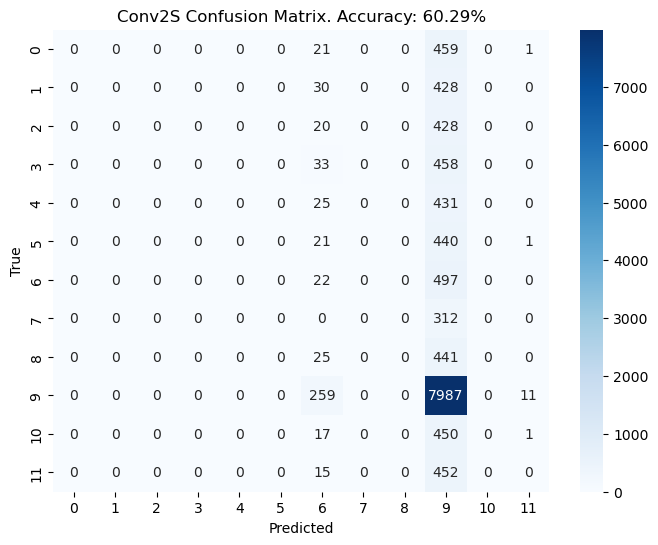

In [51]:
# Accuracy and confusion matrix calculation

convs2s_model = load_model('model.keras')
y_pred = convs2s_model.predict(X_val)
y_pred = np.squeeze(y_pred)
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(y_pred, axis=-1))

cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(y_pred, axis=-1))
print(f'Accuracy: {accuracy * 100:.2f}%')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(0, 12), yticklabels=range(0, 12))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Conv2S Confusion Matrix. Accuracy: {accuracy * 100:.2f}%')